### PRODUCTION SIMULATION USING SIMPY
##### Run simulation by calling the simulate() function, which instatiates a Production_DES object.

The simulation uses the statistical values for 'order frequency' and
'items per order' distributions obtained from online store purchases data
for a select class of product.

The Production_DES class contains the necessary attributes and methods to
model the KOGA SPORT production environment.

This simulation is useful in estimating the necessary hours of labour
required to ensure production can keep up with the given demand.

In [1]:
import simpy
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [316]:
class Production_DES(object):
    """
    A class to model the simple production queue for Koga Sport grip products with Simpy.
    
    The worker resource is only available for default=8hrs a week. Therefore the
    method obstruct_resource() is used to make the worker unavailable.
    run_manufacturing() handles the signalling of order arrivals and the creation
    of processes. Then order_manufacture handles the resource requests.
    
    Product orders are sampled from a uniform distribution, where the mean time
    bewteen orders is arrival_upper/2, using generate_order_arrival() . When an
    order is created, it then requests a worker resource, if no worker is available
    it is enqueued. For each order the amount of products in the order is sampled 
    from a geometric distribution, then the time to create the order is determined
    with generate_items_per_order(). 
    
    
    NOTE: proper implementation of num_workers>1 is not yet supported because
    obstruct_resource needs to be able to freeze all resources at once. Will 
    add soon.
    
    """


    #gamma value for geom distribution in generate_items_per_order, obtained from data
    GAMMA = 0.55
    T_PER_PRODUCT =20 #Time to produce a round of products (less than 3)
    order_number = int() 
    queue = [] 
    waittime = []

    def __init__(self, env, num_workers, worktime, resttime, arrival_upper, weeks, printsuppress):
        """
        If using the simulate() function to instatiate a Production_DES object
        the default values are:
        
        Default                Meaning
        object_name= 'sim'     Name of object
        env = 'env'            Name of simpy.Environment() instance
        num_workers = 1        Number of worker resources
        worktime = 480         Minutes worked a week
        resttime = 9600        Minutes resource not available a week
        arrival_upper = 1400   Mean wait between orders is arrival_upper/2
        weeks = 1              Weeks to run the simulation for
        printsuppress = 1      Supresses the print outputs
        """
        self.env = env #simpy.Environment()
        self.worker = simpy.PriorityResource(env, capacity =num_workers)
        self.worktime = worktime
        self.resttime = resttime
        self.arrival_upper = arrival_upper
        self.weeks = weeks
        self.printsuppress= printsuppress
        
    def run_manufacturing(self, env, worker, printsuppress):
        """
        Generates orders and thier number, calls order_manufacture() to
        request worker resource.
        """
        order_number = 0
        while True:
            order_number+=1
            yield env.timeout(self.generate_order_arrival(self.arrival_upper))
            if printsuppress== 0:
                print("Order {} is placed".format(order_number))
            env.process(self.order_manufacture(env, worker, order_number, printsuppress))
    
    def order_manufacture(self, env, worker, order_number, printsuppress):
        """
        Requests the worker resource, calls generate_items_per_order to
        calulate the time to make the order and logs waittime.
        """
        t_start = env.now
        with worker.request() as request:
            yield request
            Production_DES.queue.append(len(worker.queue))
            yield env.timeout(self.generate_items_per_order())
            if printsuppress== 0:
                print("Order {} is made".format(order_number))
            t_finish = env.now
            Production_DES.waittime.append(int(t_finish-t_start))

    def generate_items_per_order(self, gamma = GAMMA):
        """
        Generates amount of 'items per order' and the 'production time' 
        from a geometric distribution approximated from sales data.
        GAMMA is not intended to be changed as it remains constant
        when sales are scaled.
        
        3 items max can be produced at one time, therefore all order
        completion times are integer multiples of T_PER_PRODUCT.

        Scale factor '2' in 'items' adjusts the distribution to account
        for the fact that items are purchased in pairs.
        """
        
        items = 2*(np.random.geometric(gamma,1))
        if items<=3:
            return items*Production_DES.T_PER_PRODUCT
        elif items>3:
            if items%3 > 0:
                return (((items//3)*Production_DES.T_PER_PRODUCT) + Production_DES.T_PER_PRODUCT)
            else:
                return ((items//3)*Production_DES.T_PER_PRODUCT)
        else:
            print('generate_items_per_order ERROR')
    
    def generate_order_arrival(self, arrival_upper):
        """
        Generates time to next order from uniform distribution.
        Change arrival_upper to alter order frequency. Default is
        1400 minutes. The mean time bewteen orders is arrival_upper/2.
        """
        return np.random.uniform(0,arrival_upper)
    
    def obstruct_resource(self, env, worker, resttime, worktime, printsuppress):
        """
        Requests the worker resource for 'resttime' minutes to simulate the
        worker unavailability. Priority is -1 to make sure request comes
        before queued orders. 
        
        Currently not properly supported for more than 1 worker. 
        Feature needs to be added to request both worker resources at the same time.
        """
        while True:
            
            with worker.request(priority=-1) as request:
                yield request
                if printsuppress== 0:
                    print('Worker unavailable at sim time {}'.format(env.now))
                yield env.timeout(resttime)
            if printsuppress== 0:
                print('Worker available at sim time {}'.format(env.now))
            yield env.timeout(worktime)
            

    
        
        
    

In [317]:
def simulate(object_name= 'sim', env = 'env', num_workers=1, worktime=480, resttime=9600, arrival_upper = 1400, weeks = 1, printsuppress = 1):
    """
    Instantiates the environment, Production_DES object and processes then prints
    queue length and waiting time plots.
    
    Attributes and default values are: 
    env, num_workers=1, worktime=480, resttime=9600, arrival_upper=1400, weeks =1, printsuppress =1
    Time units are in minutes.
    """
    
    env = simpy.Environment()
    object_name = Production_DES(env, num_workers, worktime, resttime, arrival_upper, weeks, printsuppress)
    env.process(object_name.run_manufacturing(env, object_name.worker, object_name.printsuppress))
    env.process(object_name.obstruct_resource(object_name.env, object_name.worker, object_name.resttime,object_name.worktime, object_name.printsuppress))
    env.run(env.timeout((object_name.worktime + object_name.resttime)*object_name.weeks))
    
    print(' There are {} orders remaining in the queue after {} weeks'.format(object_name.queue[len(object_name.queue)-1], object_name.weeks))
    
    
    #fig1, q = plt.subplots()
    plt.subplot(2,2,1)
    plt.hist(object_name.queue, bins= int(round(np.log2(len(object_name.waittime)))))
    plt.xlabel("Orders in Queue")
    plt.ylabel("Frequency")
    plt.title("Queue Length Histogram")
    
    #fig2, qplot = plt.subplots()
    plt.subplot(2,2,2)
    plt.plot(object_name.queue)
    plt.xlabel("Order Number (Chronological)")
    plt.ylabel("Queue Length")
    plt.title("Queue Length For Each Order")
    
    #fig3, waithist = plt.subplots()
    plt.subplot(2,2,3)
    plt.hist(object_name.waittime, bins = int(round(np.log2(len(object_name.waittime)))))
    plt.xlabel("Wait time (minutes)")
    plt.ylabel("Frequency")
    plt.title("Wait Time Histogram")
    
    #fig4, wait = plt.subplots()
    plt.subplot(2,2,4)
    plt.plot(object_name.waittime)
    plt.xlabel("Order Number (chronological)")
    plt.ylabel("Wait Time (minutes)")
    plt.title("Wait Time For Each Order")
    
    plt.tight_layout()
   
        


#### EXAMPLE SIMULATION

 There are 3 orders remaining in the queue after 4 weeks


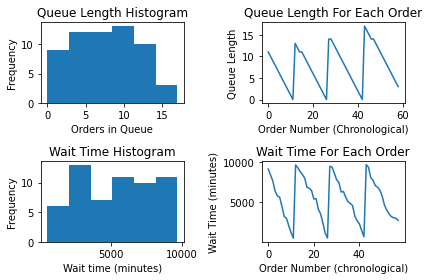

In [318]:
# defaults: simulate(object_name= 'sim', env = 'env', num_workers=1, worktime=480, resttime=9600, arrival_upper = 1400, weeks = 1, printsuppress = 1)
simulate(weeks =4, printsuppress = 1, worktime=700)